# Last time we looked a predicting District matches from the regional events. Let's add some more features to our model.

Load the training data into a pandas data frame.  

In [9]:
from __future__ import print_function
import pickle
#import time
import sys
sys.path.append('..')
import swagger_client as v3client
from swagger_client.rest import ApiException

filename = 'matches_2020.pkl'
matches = []
with open(filename, 'rb') as f:
    matches = pickle.load(f)


Preview a match object

In [27]:
non_empty = [k for k in matches['matches'].keys() if len(matches['matches'][k])>0]
data = [m for k in matches['matches'] for m in matches['matches'][k]]
data = [m for m in data if m.winning_alliance!='']
print(len(data))
red = [x for m in data for x in m.alliances.red.team_keys]
blue = [x for m in data for x in m.alliances.blue.team_keys]
from collections import Counter
Counter(red+blue)

29


Counter({'frc1153': 10,
         'frc5962': 9,
         'frc238': 9,
         'frc5687': 7,
         'frc1519': 7,
         'frc1721': 7,
         'frc296': 5,
         'frc3467': 5,
         'frc3986': 5,
         'frc1073': 8,
         'frc811': 8,
         'frc58': 8,
         'frc3117': 9,
         'frc4041': 9,
         'frc501': 9,
         'frc5813': 3,
         'frc2342': 6,
         'frc3323': 6,
         'frc4905': 6,
         'frc2084': 5,
         'frc151': 5,
         'frc157': 3,
         'frc2713': 7,
         'frc1729': 3,
         'frc4909': 5,
         'frc2079': 5,
         'frc246': 5})

In [30]:
data[0]


{'actual_time': 1581796140,
 'alliances': {'blue': {'dq_team_keys': [],
                        'score': 112,
                        'surrogate_team_keys': [],
                        'team_keys': ['frc3117', 'frc4041', 'frc501']},
               'red': {'dq_team_keys': [],
                       'score': 79,
                       'surrogate_team_keys': [],
                       'team_keys': ['frc1153', 'frc5962', 'frc238']}},
 'comp_level': 'f',
 'event_key': '2020week0',
 'key': '2020week0_f1m1',
 'match_number': 1,
 'post_result_time': 1581796502,
 'predicted_time': 1581796442,
 'score_breakdown': {'blue': {'adjustPoints': 0,
                              'autoCellPoints': 14,
                              'autoCellsBottom': 0,
                              'autoCellsInner': 1,
                              'autoCellsOuter': 2,
                              'autoInitLinePoints': 15,
                              'autoPoints': 29,
                              'controlPanelPoints'

In [31]:
Counter([x.comp_level for x in data])

Counter({'f': 2, 'qf': 9, 'qm': 14, 'sf': 4})

As you can see there is a lot of information here.  Suppose we want to collect all of this together so that at the end of the regionals we have score statistics for every team.  Let's aggregate stats for each of these fields: 'totalMatches', 
'autoPoints', 'cargoPoints', 'completeRocketRankingPoints', 'completedRocketCount', 'habLevel1Count', 'habLevel2Count', 'habLevel3Count', 'foulCount', 'foulPoints', 'rocketPanelCount', 'rocketCargoCount', 'bayPanelCount', 'bayCargoCount', 'habLineCount', 'habDockingRankingPoints', 'habClimbPoints', 'hatchPanelPoints', 'rankingPoints', 'sandStormBonusPoints', 'techFoulCount', 'teleopPoints', 'totalPoints', 'winCount'

In [32]:
qualifiers = [x for x in data if x.comp_level=='qm'] 

In [37]:
teamAggregates = {}

def addMatch(team, m):    
    if team not in teamAggregates:       
        # initialize an empty record for the team.
        teamAggregates[team]= {
            'totalMatches':0, 
            'initLineExitedCount': 0,
            'initLinePartnersExitedCount': 0,
            'endgameHungCount': 0,
            'endgamePartnersHungCount': 0,
            'endgameParkCount': 0,
            'endgamePartnersParkCount': 0,            
            'autoCellsBottomCount':0,
            'autoCellsOuterCount':0,
            'autoCellsInnerCount':0,
            'teleopCellsBottomCount':0,
            'teleopCellsOuterCount':0,
            'teleopCellsInnerCount':0,
            'stage1ActivatedCount': 0,
            'stage2ActivatedCount': 0,
            'stage3ActivatedCount': 0,
            # Anything for stage3targetcolor?
            'endgameRungIsLevelCount': 0,
            'autoInitLinePointsTotal': 0,
            'autoCellPointsTotal': 0,
            'autoPointsTotal': 0,
            'teleopCellPointsTotal': 0,
            'controlPanelPointsTotal': 0,
            'endgamePointsTotal': 0,
            'teleopPointstotal': 0,
            'shieldOperationalRankingPointsTotal': 0,
            'shieldEnergizedRankingPointsTotal': 0,
            'foulCountTotal': 0,
            'techFoulCountTotal': 0,
            'adjustPointsTotal': 0,
            'foulPointsTotal': 0,
            'rpTotal': 0,
            'totalPoints': 0,
            'winCount': 0
        }
            

    alliance = 'blue' if team in m.alliances.blue.team_keys else 'red'
    points = m.score_breakdown[alliance]
    summary = teamAggregates[team]
    # update all of the fields.
    summary['totalMatches']+=1    
    
    # TODO: figure out if we are robot 1, 2, or 3.
    iamRobot = 1
    summary['initLineExitedCount'] += 1 if points['initLineRobot{}'.format(iamRobot)]=='Exited' else 0
    summary['endgameHungCount'] += 1 if points['endgameRobot{}'.format(iamRobot)]=='Hung' else 0
    summary['endgameParkCount'] +=1 if points['endgameRobot{}'.format(iamRobot)]=='Park' else 0
    for robot in range(1,4):
        if robot == iamRobot:
            continue
        summary['initLinePartnersExitedCount'] += 1 if points['initLineRobot{}'.format(robot)]=='Exited' else 0
        summary['endgamePartnersHungCount'] += 1 if points['endgameRobot{}'.format(robot)]=='Hung' else 0
        summary['endgamePartnersParkCount'] +=1 if points['endgameRobot{}'.format(robot)]=='Park' else 0
    
    summary['autoCellsBottomCount'] += points['autoCellsBottom']
    summary['autoCellsOuterCount']+= points['autoCellsOuter']
    summary['autoCellsInnerCount'] += points['autoCellsInner']
    summary['teleopCellsBottomCount'] += points['teleopCellsBottom']
    summary['teleopCellsOuterCount'] += points['teleopCellsOuter']
    summary['teleopCellsInnerCount'] += points['teleopCellsInner']
    # TODO: Check these True/False values in sample matches
    summary['stage1ActivatedCount'] += 1 if points['stage1Activated'] == "True" else 0
    summary['stage2ActivatedCount'] += 1 if points['stage2Activated'] == "True" else 0
    summary['stage3ActivatedCount']  += 1 if points['stage3Activated'] == "True" else 0
    # Anything for stage3targetcolor?
    summary['endgameRungIsLevelCount'] += 1 if points['endgameRungIsLevel'] == "True" else 0
    summary['autoInitLinePointsTotal'] += points['autoInitLinePoints']
    summary['autoCellPointsTotal'] += points['autoCellPoints']
    summary['autoPointsTotal'] += points['autoPoints']
    summary['teleopCellPointsTotal'] += points['teleopCellPoints']
    summary['controlPanelPointsTotal'] += points['controlPanelPoints']
    summary['endgamePointsTotal']+= points['endgamePoints']
    summary['teleopPointstotal'] += points['teleopPoints']
    # TODO: check how these are recorded (true/false?)
    summary['shieldOperationalRankingPointsTotal'] += points['shieldOperationalRankingPoint']
    summary['shieldEnergizedRankingPointsTotal'] += points['shieldEnergizedRankingPoint']
    summary['foulCountTotal'] += points['foulCount']
    summary['techFoulCountTotal'] += points['techFoulCount']
    summary['adjustPointsTotal'] += points['adjustPoints']
    summary['foulPointsTotal'] += points['foulPoints'] 
    summary['rpTotal'] += points['rp']
    summary['totalPoints'] += points['totalPoints']
    summary['winCount'] += int(m.winning_alliance==alliance)

# Currently just using Week0 events.
for m in qualifiers:
    # only aggregate statistics for regional matches- skip the districts or we're cheating.
    #if m.event_key=='2020pncmp':
    #    continue
    for t in m.alliances.red.team_keys:
        addMatch(t,m)
    for t in m.alliances.blue.team_keys:
        addMatch(t,m)
        
# normalize the aggregates
for t in teamAggregates:
    for k in teamAggregates[t]:
        if k=='totalMatches':
            continue
        teamAggregates[t][k]/=teamAggregates[t]['totalMatches']

with open('teamStats_2020.pkl','wb') as f:
    pickle.dump(teamAggregates,f)

In [38]:
teamAggregates['frc1153']

{'totalMatches': 4,
 'initLineExitedCount': 0.25,
 'initLinePartnersExitedCount': 0.75,
 'endgameHungCount': 0.0,
 'endgamePartnersHungCount': 0.0,
 'endgameParkCount': 0.25,
 'endgamePartnersParkCount': 0.25,
 'autoCellsBottomCount': 0.0,
 'autoCellsOuterCount': 0.0,
 'autoCellsInnerCount': 0.0,
 'teleopCellsBottomCount': 0.0,
 'teleopCellsOuterCount': 9.0,
 'teleopCellsInnerCount': 0.25,
 'stage1ActivatedCount': 0.0,
 'stage2ActivatedCount': 0.0,
 'stage3ActivatedCount': 0.0,
 'endgameRungIsLevelCount': 0.0,
 'autoInitLinePointsTotal': 5.0,
 'autoCellPointsTotal': 0.0,
 'autoPointsTotal': 5.0,
 'teleopCellPointsTotal': 18.75,
 'controlPanelPointsTotal': 0.0,
 'endgamePointsTotal': 12.5,
 'teleopPointstotal': 31.25,
 'shieldOperationalRankingPointsTotal': 0.0,
 'shieldEnergizedRankingPointsTotal': 0.0,
 'foulCountTotal': 0.0,
 'techFoulCountTotal': 0.25,
 'adjustPointsTotal': 0.0,
 'foulPointsTotal': 0.0,
 'rpTotal': 1.5,
 'totalPoints': 36.25,
 'winCount': 0.75}

Now we have statistics for every team.  We can use this to generate features for every match.

In [58]:

def featurizeMatch(m):
    match_features = { 'red_missingCount':0, 'blue_missingCount': 0 }
    count=0    
    allKeys = set()
    for t in m.alliances.red.team_keys:
        if t not in teamAggregates:
            match_features['red_missingCount']+=1
            continue
        for k in teamAggregates[t]:
            key = 'red_'+k;
            if key not in match_features:
                match_features[key]=0
            match_features[key]+=teamAggregates[t][k]
            allKeys.add(key)
        count+=1
    # compute the average
    for k in allKeys:
        match_features[k]/=count
    count=0
    allKeys=set()
    for t in m.alliances.blue.team_keys:
        if t not in teamAggregates:
            match_features['blue_missingCount']+=1
            continue
        for k in teamAggregates[t]:
            key = 'blue_'+k;
            if key not in match_features:
                match_features[key]=0
            match_features[key]+=teamAggregates[t][k]
            allKeys.add(key)
        count+=1
    # compute the average
    for k in allKeys:
        match_features[k]/=count
    match_features['event']=m.event_key
    match_features['comp_level']=m.comp_level
    match_features['label']=int(m.winning_alliance=='red')    
    return match_features

features = []

for m in data:
    features.append(featurizeMatch(m))
    
features[0]

{'red_missingCount': 0,
 'blue_missingCount': 0,
 'red_totalMatches': 3.3333333333333335,
 'red_initLineExitedCount': 0.19444444444444442,
 'red_initLinePartnersExitedCount': 0.6944444444444443,
 'red_endgameHungCount': 0.0,
 'red_endgamePartnersHungCount': 0.0,
 'red_endgameParkCount': 0.5277777777777778,
 'red_endgamePartnersParkCount': 0.5277777777777778,
 'red_autoCellsBottomCount': 0.0,
 'red_autoCellsOuterCount': 0.3333333333333333,
 'red_autoCellsInnerCount': 0.0,
 'red_teleopCellsBottomCount': 0.7777777777777778,
 'red_teleopCellsOuterCount': 3.888888888888889,
 'red_teleopCellsInnerCount': 0.08333333333333333,
 'red_stage1ActivatedCount': 0.0,
 'red_stage2ActivatedCount': 0.0,
 'red_stage3ActivatedCount': 0.0,
 'red_endgameRungIsLevelCount': 0.0,
 'red_autoInitLinePointsTotal': 4.444444444444445,
 'red_autoCellPointsTotal': 1.3333333333333333,
 'red_autoPointsTotal': 5.777777777777778,
 'red_teleopCellPointsTotal': 8.805555555555555,
 'red_controlPanelPointsTotal': 0.0,
 'red_

In [59]:
from sklearn.feature_extraction import DictVectorizer
# create train and test sets
train = []
trainY = []
test = []
testY = []

for m in features:
    if 'event' not in m:
        print(m)
    event = m['event']
    label = m['label']
    comp_level = m['comp_level']
    del m['event']
    del m['label']
    del m['comp_level']
    #if event == '2019pncmp':
    if comp_level!='qm':
        test.append(m)
        testY.append(label)
    else:
        train.append(m)
        trainY.append(label)
        
vectorizer = DictVectorizer()
trainX = vectorizer.fit_transform(train)
testX = vectorizer.transform(test)

print('{} training examples and {} test'.format(len(train),len(test)))


14 training examples and 15 test


In [60]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=0, min_samples_split=3)  
classifier.fit(trainX,trainY)
forest_predictions= classifier.predict(testX)
import numpy as np
from sklearn.metrics import accuracy_score
#np.sum(np.abs(scores-Ytest))
accuracy_score(testY, forest_predictions)

0.6666666666666666

Let's look at the feature importances. They tell us how useful a specific feature is.

Feature ranking:


<IPython.core.display.Javascript object>


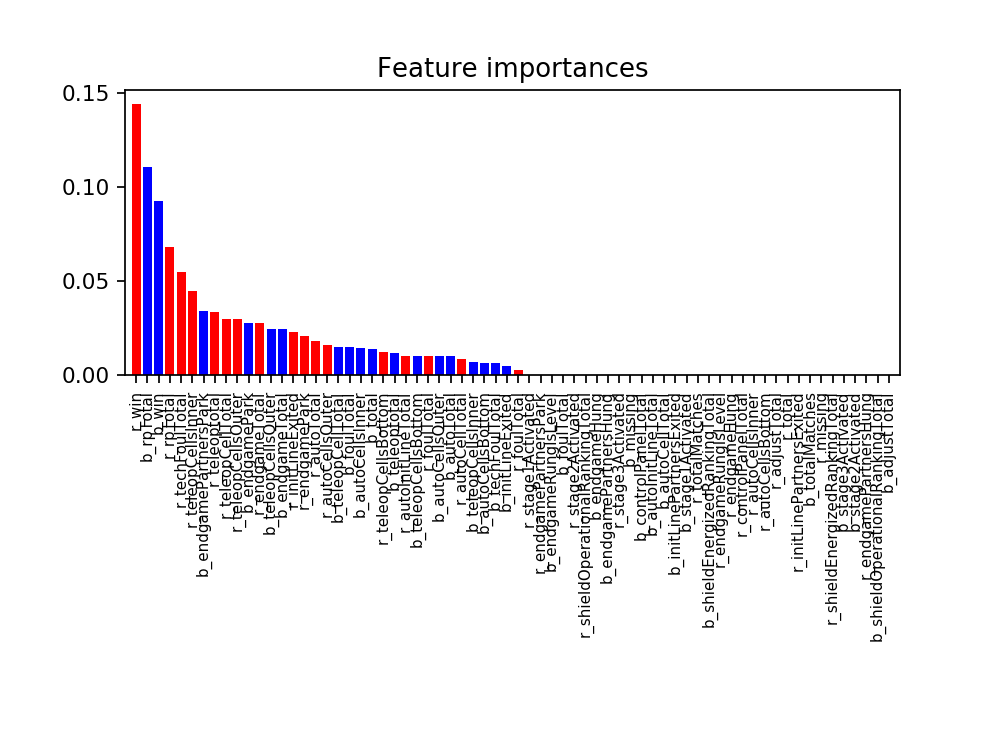

In [61]:
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = vectorizer.feature_names_

# Print the feature ranking
print("Feature ranking:")

#for f in range(trainX.shape[1]):
#    print("%d. %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))
colors = [names[indices[f]].split('_')[0] for f in range(trainX.shape[1])]
labels = [names[indices[f]].replace('Count','').replace('Points','').replace('red','r').replace('blue','b') for f in range(trainX.shape[1])]
# Plot the feature importances of the forest
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.title("Feature importances")
plt.bar(range(trainX.shape[1]), importances[indices],
       color=colors, 
        #yerr=std[indices], 
        align="center")
plt.xticks(range(trainX.shape[1]), labels, rotation='vertical', fontsize='x-small')
    
plt.xlim([-1, trainX.shape[1]])
plt.subplots_adjust(bottom=0.5)
#plt.legend()
plt.show()

## Let's also try logistic regression.

In [62]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000)
classifier.fit(trainX,trainY)
lr_predictions= classifier.predict(testX)
accuracy_score(testY, lr_predictions)

0.7333333333333333

## Linear Regression

In [53]:
from sklearn.linear_model import RidgeClassifier
classifier = RidgeClassifier()
classifier.fit(trainX,trainY)
predictions= classifier.predict(testX)
accuracy_score(testY, predictions)

0.6666666666666666

So far our best score at predicting the districts is 0.664 using either RandomForests or LogisticRegression.  Next time we can explore hyperparameter tuning and also predicting which alliances would have been the best ones for us to join.